# Load the required packages

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split   

from tensorflow.keras import models, layers 
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import optimizers


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Helper Functions

In [4]:
def model_evaluate(model, X_test, y_test):
    model = model
    model.evaluate(X_test, y_test)
    y_pred = model.predict(X_test)
    y_pred_int = np.round(y_pred).astype(int)

    cm = confusion_matrix(y_test, y_pred_int)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

In [3]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['recall'], label='train' + exp_name)
    ax1.plot(history.history['val_recall'], label='val' + exp_name)
    #ax1.set_ylim(0., 2.2)
    ax1.set_title('recall')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    #ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

In [24]:
def get_image(item):
    # file_name = f"../processed_data/{item['Cat']}/{item['image']}.jpg"
    file_name = f"../processed_data_reduce_NV/{item['Cat']}/{item['image']}.jpg"
    image = Image.open(file_name)
    width, height=image.size
    assert (width==400 and height==400), f"image: {file_name}, width: {width}, height: {height}"
    # plt.imshow(image)
    # plt.show()
    return np.asarray(image, dtype=np.float32)


# Load Processed Data

### Load meta data

In [6]:
# data = pd.read_csv('../processed_data/ISIC_2019_Training_GroundTruth_Processed_Balanced.csv')
data = pd.read_csv('../processed_data_reduce_NV/ISIC_2019_Training_GroundTruth_Processed_reduce_NV.csv')
data.head()

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK,Cat,y
0,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV,0
1,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL,1
2,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV,0
3,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL,1
4,ISIC_0000007,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV,0


the shape of the processed data setis (18331, 12)


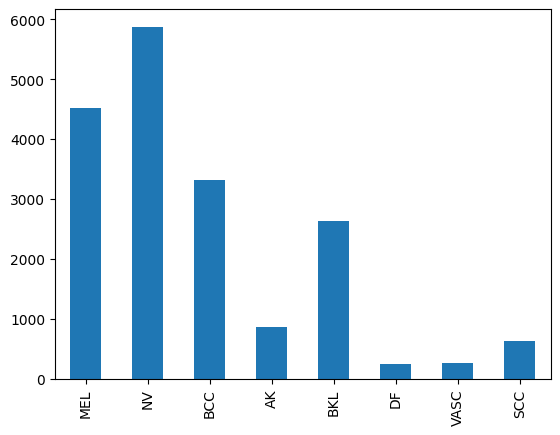

In [7]:
print(f'the shape of the processed data setis {data.shape}')
data.sum()[1:9].plot.bar();

### Load image data

In [25]:
n_samples=1000; 
sample = data.sample(n_samples, random_state=42)
# sample = data #load the full dataset

X = sample.apply(get_image, axis=1)

X = np.stack(X)
y = sample.y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(700, 400, 400, 3) (300, 400, 400, 3) (700,) (300,)


### Load image data with arugmented data

In [ ]:
def get_argumented_images(samples):
    result = []
    for i in range(samples.shape[0]):
        item = samples.iloc[i]
        if item['Cat'] == 'AK' or item['Cat'] == 'SCC':
            file_name = f"../processed_data_reduce_NV/{item['Cat']}/{item['image']}.jpg"
            image = Image.open(file_name)
            for i in range(3):
                image = image.rotate(90)
                result.append(np.asarray(image, dtype=np.float32))
            image = image.transpose(Image.FLIP_LEFT_RIGHT)
            result.append(np.asarray(image, dtype=np.float32))       
    return result

n_samples=1000; 
samples = data.sample(n_samples, random_state=42)
samples_train, samples_test= train_test_split(samples)
print(samples_train.shape, samples_test.shape)

X_train = samples_train.apply(get_image, axis=1)
X_train = np.stack(X_train)
y_train = samples_train.y

arugmented_train_samples=np.stack(get_argumented_images(samples_train))

n_added = arugmented_train_samples.shape[0]
X_train = np.vstack((X_train, arugmented_train_samples))
y_train = pd.Series(list(y_train) + [1] * n_added)

# # sample = data #load the full dataset
print(arugmented_train_samples.shape,n_added)

X_test = samples_test.apply(get_image, axis=1)
X_test = np.stack(X_test)
y_test = samples_test.y
print( X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# Modeling

## CNN Model

### build CNN Model

In [39]:
def initialize_CNN_model():
    
    model = models.Sequential()

    model.add(layers.Conv2D(16, (3, 3), input_shape = (400,400,3), activation = 'relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Conv2D(32, (3, 3), activation = 'relu', padding='same' ))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    
    model.add(layers.Conv2D(64, (3, 3), activation = 'relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    
    model.add(layers.Conv2D(64, (2, 2), activation = 'relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(units = 100, activation = 'relu'))
    model.add(layers.Dense(units = 1, activation = 'sigmoid'))

    model.compile(loss='binary_crossentropy',
                 optimizer='adam',
                 metrics =['accuracy', 'Recall'])   

    return model

### Train CNN Model

In [41]:
model_cnn = initialize_CNN_model()

es = EarlyStopping(patience=5, verbose=1)

history = model_cnn.fit(
    X_train, y_train,
    validation_split = 0.3,
    batch_size = 16,
    epochs=10,
    callbacks=[es],
    verbose = 1)

Epoch 1/10
31/31 [==============================] - 31s 950ms/step - loss: 9.9257 - accuracy: 0.5399 - recall: 0.5157 - val_loss: 0.6940 - val_accuracy: 0.5118 - val_recall: 0.0741
Epoch 2/10
31/31 [==============================] - 29s 950ms/step - loss: 0.6536 - accuracy: 0.5930 - recall: 0.5984 - val_loss: 0.6585 - val_accuracy: 0.5924 - val_recall: 0.3333
Epoch 3/10
31/31 [==============================] - 30s 976ms/step - loss: 0.6233 - accuracy: 0.6196 - recall: 0.5945 - val_loss: 0.6853 - val_accuracy: 0.5308 - val_recall: 0.6944
Epoch 4/10
31/31 [==============================] - 29s 949ms/step - loss: 0.5872 - accuracy: 0.6564 - recall: 0.6811 - val_loss: 0.7135 - val_accuracy: 0.5308 - val_recall: 0.5648
Epoch 5/10
31/31 [==============================] - 29s 925ms/step - loss: 0.5418 - accuracy: 0.7526 - recall: 0.7717 - val_loss: 0.7340 - val_accuracy: 0.5403 - val_recall: 0.3704
Epoch 6/10
31/31 [==============================] - 29s 926ms/step - loss: 0.5469 - accuracy: 0

## VGG16 Transfer Learning

### Build VGG Model

In [42]:
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16

def load_vgg_model():
    model = VGG16(weights="imagenet", include_top=False, input_shape=X_train[0].shape)
    return model

def set_nontrainable_layers(model):
    # Set the first layers to be untrainable
    model.trainable = False

    return model

def add_last_layers(model):
    '''Take a pre-trained model, set its parameters as non-trainable, and add additional trainable layers on top'''

    base_model = set_nontrainable_layers(model)
    flatten_layer = layers.Flatten()
    dense_layer = layers.Dense(200, activation='relu')
    prediction_layer = layers.Dense(1, activation='sigmoid')

    model = models.Sequential([
        base_model,
        flatten_layer,
        dense_layer,
        prediction_layer
    ])

    return model

def build_vgg_model():

    model = load_vgg_model()
    model = add_last_layers(model)

    opt = optimizers.Adam(learning_rate=0.001)
    model.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy', 'Recall'])
    return model


### Data Preprocessing

In [43]:
X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)

### Train VGG Model

In [44]:
model_vgg = build_vgg_model()

es = EarlyStopping(monitor = 'val_accuracy',
                   mode = 'max',
                   patience = 5,
                   verbose = 1,
                   restore_best_weights = True)
# 
history = model_vgg.fit(X_train, y_train,
                    validation_split=0.3,
                    epochs=10,
                    batch_size=32,
                    callbacks=[es])

Epoch 1/10
16/16 [==============================] - 391s 25s/step - loss: 9.6443 - accuracy: 0.5501 - recall: 0.6142 - val_loss: 2.7449 - val_accuracy: 0.6398 - val_recall: 0.6019
Epoch 2/10
16/16 [==============================] - 388s 25s/step - loss: 0.6978 - accuracy: 0.8507 - recall: 0.8425 - val_loss: 1.4483 - val_accuracy: 0.6493 - val_recall: 0.8796
Epoch 3/10
16/16 [==============================] - 367s 23s/step - loss: 0.2088 - accuracy: 0.9039 - recall: 0.8937 - val_loss: 1.4879 - val_accuracy: 0.6445 - val_recall: 0.9074
Epoch 4/10
16/16 [==============================] - 364s 23s/step - loss: 0.0744 - accuracy: 0.9775 - recall: 0.9921 - val_loss: 1.0161 - val_accuracy: 0.6825 - val_recall: 0.6667
Epoch 5/10
16/16 [==============================] - 373s 24s/step - loss: 0.0253 - accuracy: 0.9898 - recall: 0.9843 - val_loss: 1.5341 - val_accuracy: 0.6872 - val_recall: 0.8148
Epoch 6/10
16/16 [==============================] - 354s 23s/step - loss: 0.0125 - accuracy: 0.9959 

## ResNET

In [45]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

# Load the pre-trained ResNet50 model without the top (fully connected) layers
def load_ResNet50_model():
    model = ResNet50(weights='imagenet', include_top=False, input_shape=X_train[0].shape)
    return model
def set_nontrainable_layers(model):
    # Set the first layers to be untrainable
    model.trainable = False

    return model
def add_last_layers(model):
    '''Take a pre-trained model, set its parameters as non-trainable, and add additional trainable layers on top'''

    base_model = set_nontrainable_layers(model)
    flatten_layer = layers.Flatten()
    dense_layer = layers.Dense(200, activation='relu')
    prediction_layer = layers.Dense(1, activation='sigmoid')

    model = models.Sequential([
        base_model,
        flatten_layer,
        dense_layer,
        prediction_layer
    ])

    return model

In [46]:
def build_ResNet50_model():

    model = load_ResNet50_model()
    model = add_last_layers(model)

    opt = optimizers.Adam(learning_rate=0.001)
    model.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy', 'Recall'])
    return model


In [47]:
X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)

In [48]:
ResNet50_model = build_ResNet50_model()

es = EarlyStopping(monitor = 'val_accuracy',
                   mode = 'max',
                   patience = 5,
                   verbose = 1,
                   restore_best_weights = True)
history = ResNet50_model.fit(X_train, y_train,
                    validation_split=0.3,
                    epochs=10,
                    batch_size=32,
                    callbacks=[es])

Epoch 1/10
16/16 [==============================] - 175s 11s/step - loss: 36.6502 - accuracy: 0.5174 - recall: 0.5630 - val_loss: 4.4305 - val_accuracy: 0.6114 - val_recall: 0.9537
Epoch 2/10
16/16 [==============================] - 157s 10s/step - loss: 1.2054 - accuracy: 0.7178 - recall: 0.7205 - val_loss: 0.6568 - val_accuracy: 0.5450 - val_recall: 1.0000
Epoch 3/10
16/16 [==============================] - 159s 10s/step - loss: 0.5949 - accuracy: 0.6360 - recall: 0.9528 - val_loss: 0.7236 - val_accuracy: 0.6351 - val_recall: 0.6944
Epoch 4/10
16/16 [==============================] - 161s 10s/step - loss: 0.5497 - accuracy: 0.6728 - recall: 0.9449 - val_loss: 0.6421 - val_accuracy: 0.5687 - val_recall: 1.0000
Epoch 5/10
16/16 [==============================] - 162s 10s/step - loss: 0.5190 - accuracy: 0.6667 - recall: 0.9961 - val_loss: 0.6063 - val_accuracy: 0.6303 - val_recall: 0.9722
Epoch 6/10
16/16 [==============================] - 159s 10s/step - loss: 0.4848 - accuracy: 0.7280

## InceptionResNetV2

In [9]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input

# Load the pre-trained ResNet50 model without the top (fully connected) layers
def load_InceptionResNetV2_model():
    model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=X_train[0].shape)
    return model

def set_nontrainable_layers(model):
    # Set the first layers to be untrainable
    model.trainable = False

    return model
def add_last_layers(model):
    '''Take a pre-trained model, set its parameters as non-trainable, and add additional trainable layers on top'''

    base_model = set_nontrainable_layers(model)
    flatten_layer = layers.Flatten()
    dense_layer = layers.Dense(200, activation='relu')
    prediction_layer = layers.Dense(1, activation='sigmoid')

    augmentation = models.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomZoom(0.1),
        # layers.RandomTranslation(0.2, 0.2),
        layers.RandomRotation(0.1)
    ])

    model = models.Sequential([
        layers.Input(input_shape=X_train[0].shape),
        augmentation,
        base_model,
        flatten_layer,
        dense_layer,
        prediction_layer
    ])

    return model
def build_InceptionResNetV2_model():
    model = load_InceptionResNetV2_model()
    model = add_last_layers(model)

    opt = optimizers.Adam(learning_rate=0.001)
    model.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy', 'Recall'])
    return model



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 11, 11, 1536)     54336736  
 onal)                                                           
                                                                 
 flatten (Flatten)           (None, 185856)            0         
                                                                 
 dense (Dense)               (None, 200)               37171400  
                                                                 
 dense_1 (Dense)             (None, 1)                 201       
                                                                 
Total params: 91,508,337
Trainable params: 37,171,601
Non-trainable params: 54,336,736
_________________________________________________________________


In [10]:
X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)

In [11]:
model_InceptionResNetV2 = build_InceptionResNetV2_model()
lr = ReduceLROnPlateau(monitor="val_loss",
                       factor=0.1,
                       patience=2,
                       verbose=1,
                       min_lr=0)

es = EarlyStopping(monitor = 'val_accuracy',
                   mode = 'max',
                   patience = 10,
                   verbose = 1,
                   restore_best_weights = True)

history = model_InceptionResNetV2.fit(X_train, y_train,
                    validation_split=0.3,
                    epochs=50,
                    batch_size=16,
                    callbacks=[es, lr])

Epoch 1/50
31/31 [==============================] - 570s 18s/step - loss: 8.2817 - accuracy: 0.6966 - recall: 0.7885 - val_loss: 2.2070 - val_accuracy: 0.7173 - val_recall: 0.7189
Epoch 2/50
31/31 [==============================] - 523s 17s/step - loss: 0.9865 - accuracy: 0.8539 - recall: 0.8994 - val_loss: 2.8625 - val_accuracy: 0.6817 - val_recall: 0.6762
Epoch 3/50
31/31 [==============================] - 558s 18s/step - loss: 0.4717 - accuracy: 0.9081 - recall: 0.9334 - val_loss: 2.5231 - val_accuracy: 0.6865 - val_recall: 0.6370
Epoch 4/50
31/31 [==============================] - 612s 20s/step - loss: 0.1402 - accuracy: 0.9642 - recall: 0.9734 - val_loss: 2.0847 - val_accuracy: 0.7553 - val_recall: 0.8363
Epoch 5/50
31/31 [==============================] - 703s 23s/step - loss: 0.0777 - accuracy: 0.9785 - recall: 0.9822 - val_loss: 2.4353 - val_accuracy: 0.6675 - val_recall: 0.6050
Epoch 6/50
31/31 [==============================] - 755s 25s/step - loss: 0.1222 - accuracy: 0.9683 

KeyboardInterrupt: 

## Evaluate Model

(<Axes: title={'center': 'recall'}>, <Axes: title={'center': 'Accuracy'}>)

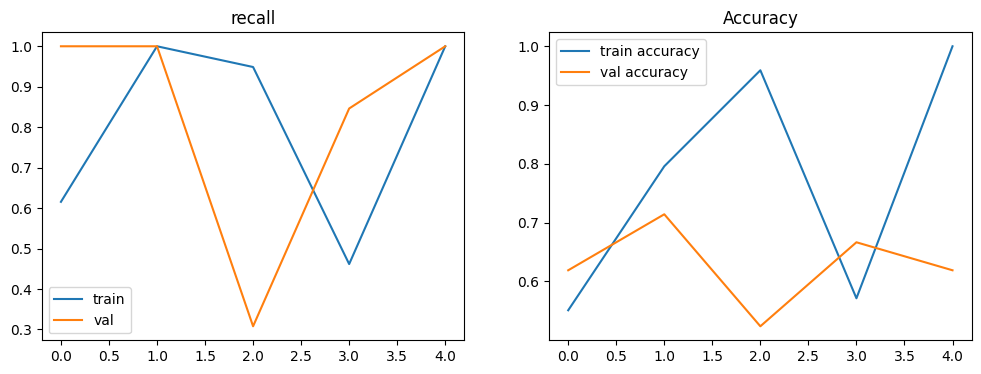

In [20]:
# model_evaluate(ResNet50_model, X_test, y_test)
plot_history(history)

# Save the trained model

In [ ]:
# Serialize the trained model
model_name= 'model_dummy'
import pickle
file_name_pickle = f'../{model_name}.pickle'
with open(file_name_pickle, 'wb') as file:
    pickle.dump(model, file)